In [1]:
# Import the required libraries and dependencies
import numpy as np
import pandas as pd
import os
import requests
import json
from pathlib import Path
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from dotenv import load_dotenv
#from MCForecastTools import MCSimulation

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## PART 1: Prepare Data

In [2]:
#Read CSV file from the Resources folder into a Pandas Dataframe

realtor_data = pd.read_csv(
    Path("Resources/realtor_data.csv")
        )
    
#Review the dataframe 
realtor_data

,status,price,bed,bath,acre_lot,full_address,street,city,state,zip_code,house_size,sold_date
0,for_sale,105000.0,3.0,2.0,0.12,"Sector Yahuecas Titulo # V84, Adjuntas, PR, 00601",Sector Yahuecas Titulo # V84,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,for_sale,80000.0,4.0,2.0,0.08,"Km 78 9 Carr # 135, Adjuntas, PR, 00601",Km 78 9 Carr # 135,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,for_sale,67000.0,2.0,1.0,0.15,"556G 556-G 16 St, Juana Diaz, PR, 00795",556G 556-G 16 St,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,for_sale,145000.0,4.0,2.0,0.10,"R5 Comunidad El Paraso Calle De Oro R-5 Ponce,...",R5 Comunidad El Paraso Calle De Oro R-5 Ponce,Ponce,Puerto Rico,731.0,1800.0,NaN
4,for_sale,65000.0,6.0,2.0,0.05,"14 Navarro, Mayaguez, PR, 00680",14 Navarro,Mayaguez,Puerto Rico,680.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
402154,for_sale,299900.0,4.0,3.0,0.29,"299 Evening Star Dr, Naugatuck, CT, 06770",299 Evening Star Dr,Naugatuck,Connecticut,6770.0,2374.0,2017-06-27
402155,for_sale,275000.0,3.0,2.0,0.53,"570 Witches Rock Rd, Bristol, CT, 06010",570 Witches Rock Rd,Bristol,Connecticut,6010.0,1548.0,2002-06-17
402156,for_sale,99900.0,2.0,1.0,0.11,"335 Raymond St, Waterbury, CT, 06706",335 Raymond St,Waterbury,Connecticut,6706.0,569.0,NaN
402157,for_sale,259700.0,3.0,2.0,0.83,"14 S Main St, East Granby, CT, 06026",14 S Main St,East Granby,Connecticut,6026.0,1656.0,NaN


In [3]:
#Review categories
realtor_data.columns
#Notes: inputs
#bed, bath, acre, state, house_size 
#target: price

Index(['status', 'price', 'bed', 'bath', 'acre_lot', 'full_address', 'street',
       'city', 'state', 'zip_code', 'house_size', 'sold_date'],
      dtype='object')

In [4]:
# Drop unncessary data 
#Added "zip_code" back into data set, improved values
realtor_data = realtor_data.drop(columns = ['bath', 'zip_code','status', 'full_address', 'street', 'city', 'sold_date'])
#Review Dataframe
realtor_data

,price,bed,acre_lot,state,house_size
0,105000.0,3.0,0.12,Puerto Rico,920.0
1,80000.0,4.0,0.08,Puerto Rico,1527.0
2,67000.0,2.0,0.15,Puerto Rico,748.0
3,145000.0,4.0,0.10,Puerto Rico,1800.0
4,65000.0,6.0,0.05,Puerto Rico,NaN
...,...,...,...,...,...
402154,299900.0,4.0,0.29,Connecticut,2374.0
402155,275000.0,3.0,0.53,Connecticut,1548.0
402156,99900.0,2.0,0.11,Connecticut,569.0
402157,259700.0,3.0,0.83,Connecticut,1656.0


In [5]:
realtor_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402159 entries, 0 to 402158
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   price       402159 non-null  float64
 1   bed         314887 non-null  float64
 2   acre_lot    326858 non-null  float64
 3   state       402159 non-null  object 
 4   house_size  318977 non-null  float64
dtypes: float64(4), object(1)
memory usage: 15.3+ MB


In [6]:
#Counting number of states 
realtor_data['state'].value_counts()

Massachusetts     173162
New Hampshire      51394
Vermont            46460
Maine              36650
Connecticut        32768
Rhode Island       28518
Puerto Rico        24679
New York            5828
Virgin Islands      2573
Georgia               48
South Carolina        24
Tennessee             20
Virginia              20
New Jersey            12
Wyoming                3
Name: state, dtype: int64

In [7]:
#Transform categorical variables

from sklearn.preprocessing import OneHotEncoder
#Create Instance
enc = OneHotEncoder(handle_unknown='ignore')
#Fit instance to categorical data
enc.fit(realtor_data[['state']])

#Transform data and create DataFrame
categories = enc.transform(realtor_data[['state']])

#Create Pandas Dataframe

lorem = pd.DataFrame(categories.toarray(),columns = enc.categories_)
#Review dataframe
display(lorem)

#pd.DataFrame(enc.fit_transform(realtor_data[['states']]).toarray())

#drop_enc = pd.DataFrame(OneHotEncoder().fit(realtor_data["state"].value_counts()))

#enc = OneHotEncoder(handle_unknown='ignore')
#enc_df = pd.DataFrame(enc.fit_transform(bridge_df[['Bridge_Types_Cat']]).toarray())


,Connecticut,Georgia,Maine,Massachusetts,New Hampshire,New Jersey,New York,Puerto Rico,Rhode Island,South Carolina,Tennessee,Vermont,Virgin Islands,Virginia,Wyoming
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402154,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
402155,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
402156,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
402157,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
#Review categories

enc.categories_

[array(['Connecticut', 'Georgia', 'Maine', 'Massachusetts',
        'New Hampshire', 'New Jersey', 'New York', 'Puerto Rico',
        'Rhode Island', 'South Carolina', 'Tennessee', 'Vermont',
        'Virgin Islands', 'Virginia', 'Wyoming'], dtype=object)]

In [9]:
#Omit Puerto Rico and Virigin Islands to avoid Colinearity issues
#Rename
lorem = lorem.drop(columns = ['Virgin Islands','Puerto Rico'])

display(lorem)

,Connecticut,Georgia,Maine,Massachusetts,New Hampshire,New Jersey,New York,Rhode Island,South Carolina,Tennessee,Vermont,Virginia,Wyoming
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
402154,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
402155,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
402156,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
402157,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
#Concatenate new dataframe to exisitng dataframe

realtor_states_enc = pd.concat([realtor_data,lorem], axis = 1)

#Drop states column
realtor_states_enc = realtor_states_enc.drop(columns = ['state'])

#Review Dataframe
realtor_states_enc.head(10)

realtor_states_enc.columns = ['price','bed', 'acre_lot', 'house_size', 
                          'Connecticut', 'Georgia', 'Maine', 'Massachusetts',
                          'New Hampshire', 'New Jersey', 'New York', 
                          'Rhode Island', 'South Carolina', 'Tennessee', 'Vermont',
                          'Virginia', 'Wyoming']

In [11]:
realtor_states_enc.head()

,price,bed,acre_lot,house_size,Connecticut,Georgia,Maine,Massachusetts,New Hampshire,New Jersey,New York,Rhode Island,South Carolina,Tennessee,Vermont,Virginia,Wyoming
0,105000.0,3.0,0.12,920.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,80000.0,4.0,0.08,1527.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,67000.0,2.0,0.15,748.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,145000.0,4.0,0.10,1800.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,65000.0,6.0,0.05,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Drop states with problematic data
realtor_states_enc = realtor_states_enc.drop(columns = ["Georgia", "South Carolina", "Tennessee", "Virginia"])

In [13]:
#Drop null values
realtor_states_enc = realtor_states_enc.dropna()

In [14]:
#Review Data to ensure dataframe is ready for training model
realtor_states_enc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240612 entries, 0 to 402158
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   price          240612 non-null  float64
 1   bed            240612 non-null  float64
 2   acre_lot       240612 non-null  float64
 3   house_size     240612 non-null  float64
 4   Connecticut    240612 non-null  float64
 5   Maine          240612 non-null  float64
 6   Massachusetts  240612 non-null  float64
 7   New Hampshire  240612 non-null  float64
 8   New Jersey     240612 non-null  float64
 9   New York       240612 non-null  float64
 10  Rhode Island   240612 non-null  float64
 11  Vermont        240612 non-null  float64
 12  Wyoming        240612 non-null  float64
dtypes: float64(13)
memory usage: 25.7 MB


## PART 2: Linear Regression Model

In [29]:
#Load dataset

#Target
y = realtor_states_enc[['price']]
#Inputs
X = realtor_states_enc.drop(columns = y)

#Review Data
display(y)
display(X)

,price
0,105000.0
1,80000.0
2,67000.0
3,145000.0
5,179000.0
...,...
402154,299900.0
402155,275000.0
402156,99900.0
402157,259700.0


,bed,acre_lot,house_size,Connecticut,Maine,Massachusetts,New Hampshire,New Jersey,New York,Rhode Island,Vermont,Wyoming
0,3.0,0.12,920.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,0.08,1527.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.15,748.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.10,1800.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.46,2520.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
402154,4.0,0.29,2374.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
402155,3.0,0.53,1548.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
402156,2.0,0.11,569.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
402157,3.0,0.83,1656.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
#Check for colinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

display(calc_vif(X_train))

,variables,VIF
0,bed,3.320117
1,acre_lot,1.002838
2,house_size,1.524808
3,Connecticut,1.201273
4,Maine,1.174081
5,Massachusetts,2.023046
6,New Hampshire,1.176124
7,New Jersey,1.000063
8,New York,1.028468
9,Rhode Island,1.208330


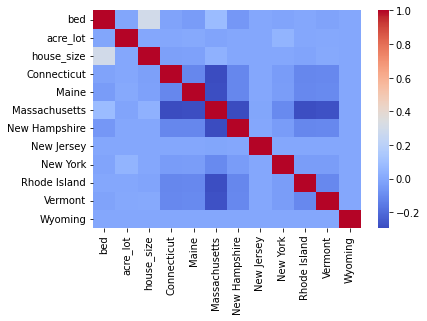

In [22]:
#Heat Map
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()
sns.heatmap(X_train.corr(), cmap='coolwarm')
plt.show()
#sns.lmplot(x=X_train, y=y_train, data=X_train)

In [30]:
#Prepare Data

from sklearn.model_selection import train_test_split

#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

In [37]:
y_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60153 entries, 214966 to 224979
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   60153 non-null  float64
dtypes: float64(1)
memory usage: 939.9 KB


Coefficients: 
 [[1.12633482e+05 1.04144661e+01 6.75760671e+01 4.09032305e+04
  1.55967025e+05 6.06293466e+05 2.66644992e+05 7.09269990e+04
  8.74182638e+04 1.10008058e+05 1.57594465e+05 2.43039119e+05]]
Mean squared error: 1041620265461.93
Coefficient of determination: 0.24


ValueError: x and y must be the same size

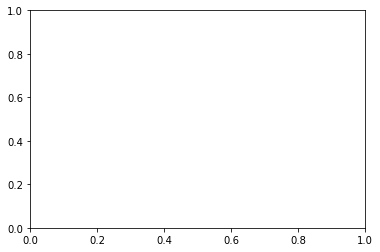

In [39]:
#Linear Regression Model
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt

#Instantiate Linear Regression Model
linear_model = linear_model.LinearRegression()

#Fit Model
linear_model.fit(X_train,y_train)

#Predict
linear_y_pred = linear_model.predict(X_test)

# The coefficients
print("Coefficients: \n", linear_model.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, linear_y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test,linear_y_pred))

# Plot outputs
plt.scatter(X_test, y_test, color="black")
plt.plot(dX_test, linear_y_pred, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

## PART 3: Random Forrest Model

In [42]:
#Random Forrest Model

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

#Instantiate Random Forrest Model
rfr = RandomForestRegressor(n_estimators = 500, random_state = 1)

#Fit Model
rfr.fit(X_train, y_train)

#Create Predictions
rfr_pred = rfr.predict(X_train)

#print(rfr.score(X_test, y_test))

#rfr.score(X_test, y_test)

#y_pred = model.predict(X_test)
#y_pred[:5]


1041620265461.9287


In [44]:
#The coefficients
ms_error = mse(y_test, y_pred)
print(ms_error)

ma_error = mae(y_test, y_pred)
print(ma_error)

1041620265461.9287
458175.5411512883


## PART 4: Comparison of Models

In [48]:
#Prediction Scores
#Default: 0.26660702141642834
#Dropping 'bed': 0.24097292779192903
#Dropping 'bath': 0.1697949088216184
train_score = model.score(X_train, y_train)

#Validate Prediction Scores
#Default: 0.1792303300803011
#Dropping 'bed': 0.2596970439636055
#Dropping 'bath':0.2538660071973995
test_score = model.score(X_test, y_test)

#Compute deltas
delta = abs(train_score - test_score)

display(train_score)
display(test_score)
display(delta)
    

0.16979490882161574

0.2538660071974075

0.08407109837579174

## PART 5: Next Steps and MISC Code

In [ ]:
#Steps for improving models
#1. Encapsulate zip code with median house price
#2. 30 year fixed mortage rate

In [ ]:
#MISC CODE
#realtor_data['sold_date']=pd.to_datetime(realtor_data['sold_date'], infer_datetime_format=True)
#realtor_data['sold_date'].dt.year
#realtor_data = realtor_data[realtor_data['sold_date'].notna()]
#realtor_data['sold_date'].isna().sum()
#Plot Data
#realtor_data.groupby([realtor_data['sold_date'].dt.year, realtor_data['sold_date'].dt.month])['price'].mean().plot(figsize=(15, 5))
#from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
#r2_score(y_train,y_test)

#sklearn.metrics.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)

#Make the API Calls
# Make the API request
#response = requests.get("endpoint").json()

# Display the response data
#print(json.dumps(response, indent=4, sort_keys=True)